# Visualize time series data sample from healthcare dataset

*Suiyi Liu, 2023.7.10*

- read dataset: transform patient record into standard time series form
- visualize the observed data in certain sample record
- visualize a certain attribute in a butch of patient records
- missing ratio of one attribute in different hours
- correlations of missing pattern between attributes
- time series normailization: z-score standard, and some fansy algorithm
- correlations of observed values in different attributes

*Note: limited to capicity of personal computer, only a small sample is chosen from complete dataset for demonstration*

## read patient records

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re
import os,sys
import warnings
import seaborn as sns

os.chdir(sys.path[0])
warnings.filterwarnings("ignore")
rc("font",family="MicroSoft YaHei",weight="bold") #chinese in labels

In [2]:
# known info about attributes and timespan
attr_count=35
hour_count=48

# 35 attributes which contains enough non-values
attributes = ['DiasABP', 'HR', 'Na', 'Lactate', 'NIDiasABP', 'PaO2', 'WBC', 'pH', 'Albumin', 'ALT', 'Glucose', 'SaO2',
              'Temp', 'AST', 'Bilirubin', 'HCO3', 'BUN', 'RespRate', 'Mg', 'HCT', 'SysABP', 'FiO2', 'K', 'GCS',
              'Cholesterol', 'NISysABP', 'TroponinT', 'MAP', 'TroponinI', 'PaCO2', 'Platelets', 'Urine', 'NIMAP',
              'Creatinine', 'ALP']

def extract_hour(x)->int:
    """convert string type index into int type"""
    h, _ = map(int, x.split(":"))
    return h

def parse_data(x)->list[float]:
    """extract the last value for each attribute"""
    x = x.set_index("Parameter").to_dict()["Value"]
    values = []

    for attr in attributes:
        if x.__contains__(attr):
            values.append(x[attr])
        else:
            values.append(np.nan)
    return values

def read_record(path:str)->pd.DataFrame:
    dataset_raw=pd.read_csv(path)
    dataset_raw["Time"]=dataset_raw["Time"].apply(lambda x: extract_hour(x))

    _list:list[list[float]]=[]
    for h in range(48):
        _list.append(parse_data(dataset_raw[dataset_raw["Time"] == h]))
    dataset=pd.DataFrame(_list,columns=attributes)
    return dataset


## take a glance at certain one patient record

In [ ]:
"""take a glance at certain one patient record, no normalization cast"""
dataset=read_record("./sample_data.csv")
dataset_valid=dataset.dropna(how="all",axis=1)
dataset_valid.head()

In [ ]:

plt.rcParams["font.size"] = 16
L,K=dataset_valid.shape

fig, axes = plt.subplots(nrows=int(np.ceil(K/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,attr in zip(range(K),dataset_valid.columns):
    df=pd.DataFrame({"x":np.arange(0,L),"val":dataset_valid[attr]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].set_xlim((0,L))
    axes[row][col].set_title(attr)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
#plt.suptitle("observed values in sample data")
plt.show()
    

## take a glance at certain one attribute in butch of records

In [3]:
"""read a butch of patient records (maybe all of, but personal computer cannot carry that way)"""

def get_idlist()->list:
    """get patient id from file names in 6 digital form and sort"""
    patient_id = []
    for filename in os.listdir("../data/physio/set-a"):
        match = re.search(r"\d{6}", filename) 
        if match:
            patient_id.append(match.group())
    patient_id = np.sort(patient_id)
    return patient_id.tolist()

def read_dataset_tolist(count:int=100)->tuple[list[pd.DataFrame],list[str]]:
    id_list=get_idlist() #full record count : 4000
    id_list=id_list[0:count] # for a preview
    dataset_list:list[pd.DataFrame]=[]
    for _id in id_list:
        try:
            dataset=read_record("../data/physio/set-a/{}.txt".format(_id))
            dataset_list.append(dataset)
        except IOError as e:
            print(_id,e)
            continue
    return dataset_list,id_list

def read_dataset_toDF(count:int)->pd.DataFrame:
    id_list=get_idlist() #full record count : 4000
    id_list=id_list[0:count] # for a preview
    dataset_df=pd.DataFrame(columns=attributes,index=id_list)
    for _id in id_list:
        try:
            dataset=read_record("../data/physio/set-a/{}.txt".format(_id))
            _array=np.array(dataset.values).transpose().tolist()
            _list=[_array]
            dataset_df.loc[[_id]]=_list
        except IOError as e:
            print(_id,e)
            continue
    return dataset_df


In [ ]:
"""take a glance at certain one attribute in butch of records, no normalization cast"""
dataset_list,id_list=read_dataset_tolist(count=50)
target_attr="NIDiasABP"

In [ ]:
attr_df=pd.DataFrame(columns=id_list)
for k in range(0,len(id_list)):
    _id=id_list[k]
    _values=dataset_list[k][target_attr]
    attr_df[_id]=_values
attr_df=attr_df.dropna(how="all",axis=1)
attr_df.head()

In [ ]:

plt.rcParams["font.size"] = 16
L,K=attr_df.shape

fig, axes = plt.subplots(nrows=int(np.ceil(K/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,_id in zip(range(K),attr_df.columns):
    df=pd.DataFrame({"x":np.arange(0,L),"val":attr_df[_id]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].set_xlim((0,L))
    axes[row][col].set_title(_id)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel=target_attr)
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
plt.show()

## missing ratio in certain attribute

In [4]:
dataset_list,id_list=read_dataset_tolist(count=100)
attr_df=pd.DataFrame(columns=id_list)
target_attr="NIDiasABP"
for k in range(0,len(id_list)):
    _id=id_list[k]
    _values=dataset_list[k][target_attr]
    attr_df[_id]=_values

In [26]:
observed_count=attr_df.isna().sum(axis=1)
observed_count/=df.shape[1]
missing_ratio=np.ones(hour_count)-observed_count.values #type:ignore

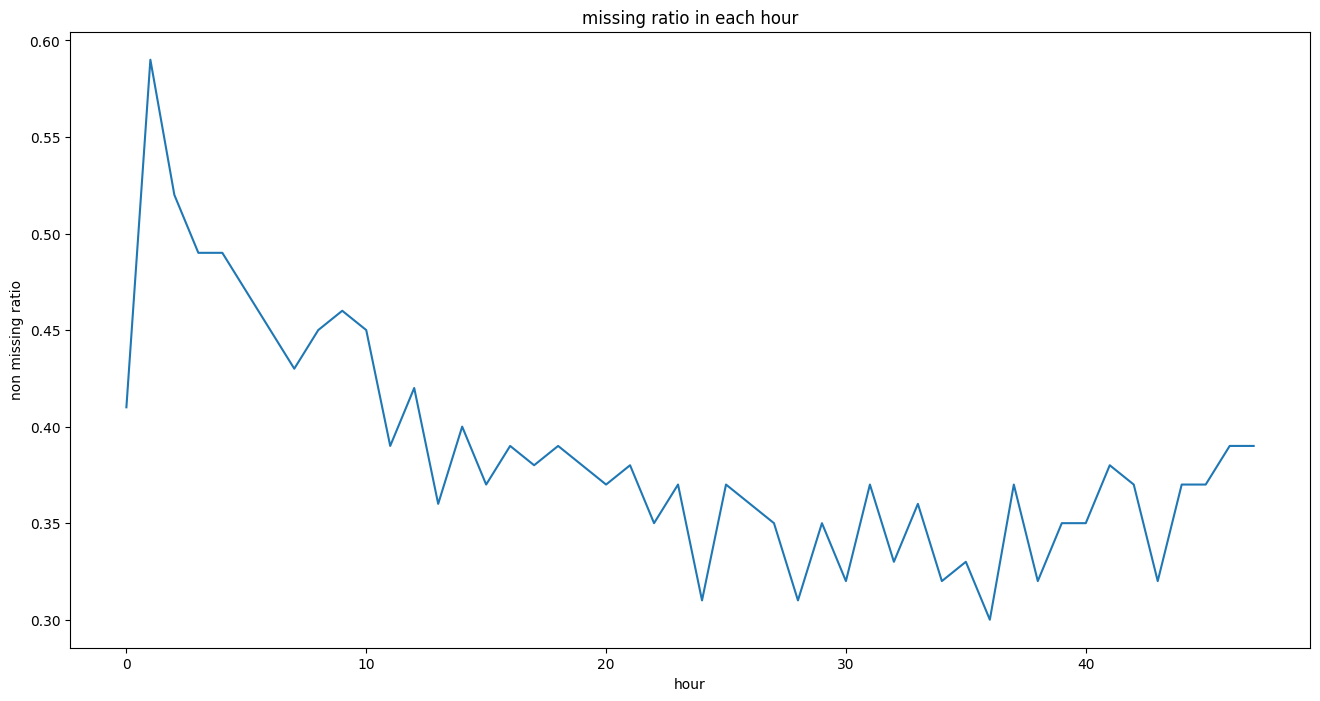

In [28]:
fig=plt.figure(figsize=(16,8))
plt.title("missing ratio of "+target_attr+" in each hour")
plt.plot(range(0,hour_count),missing_ratio)
plt.xlabel("hour")
plt.ylabel("missing ratio")
plt.show()

## missing ratio in timespan of all attributes

In [23]:
df_all=read_dataset_toDF(count=100)
df_all=df_all.applymap(lambda x:np.array(x))
df_all.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[77.0, 60.0, 62.0, 80.0, 74.0, 73.0, nan, 64.0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[58.0, 62.0, 52.0, 52.0, nan, 45.0, nan, 49.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[157.0, 137.0, 123.0, 114.0, nan, 110.0, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[60.0, 30.0, 170.0, 60.0, nan, 170.0, nan, 120...","[91.0, 87.0, 75.67, 72.67, nan, 66.67, nan, 68...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [24]:
df_missVal=df_all.applymap(lambda x:np.isnan(x))
df_missVal.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...",...,"[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, True, False, True...","[False, False, False, False, True, False, True...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru..."


In [16]:
df_missRatio=pd.DataFrame(columns=attributes)
_df=df_missVal.applymap(lambda x:np.array(x,dtype=int))
for attr in attributes:
    _values=np.array(_df[attr],dtype=np.ndarray)
    df_missRatio[attr]=_values.sum()/df_missVal.shape[0]

df_missRatio.head()

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
0,0.81,0.47,0.88,0.94,0.59,0.82,0.88,0.81,0.94,0.93,...,0.59,0.99,0.81,0.99,0.81,0.87,0.72,0.59,0.87,0.93
1,0.66,0.23,0.85,0.91,0.41,0.80,0.82,0.80,0.94,0.93,...,0.41,0.97,0.66,0.99,0.81,0.80,0.43,0.41,0.81,0.93
2,0.59,0.18,0.90,0.91,0.48,0.78,0.91,0.76,0.97,0.97,...,0.48,0.98,0.59,1.00,0.77,0.89,0.33,0.48,0.89,0.97
3,0.55,0.16,0.88,0.91,0.51,0.80,0.91,0.80,0.96,0.95,...,0.51,0.99,0.55,0.97,0.80,0.89,0.36,0.52,0.89,0.95
4,0.52,0.13,0.90,0.93,0.51,0.77,0.91,0.77,0.98,0.97,...,0.51,1.00,0.54,1.00,0.77,0.89,0.41,0.51,0.87,0.97


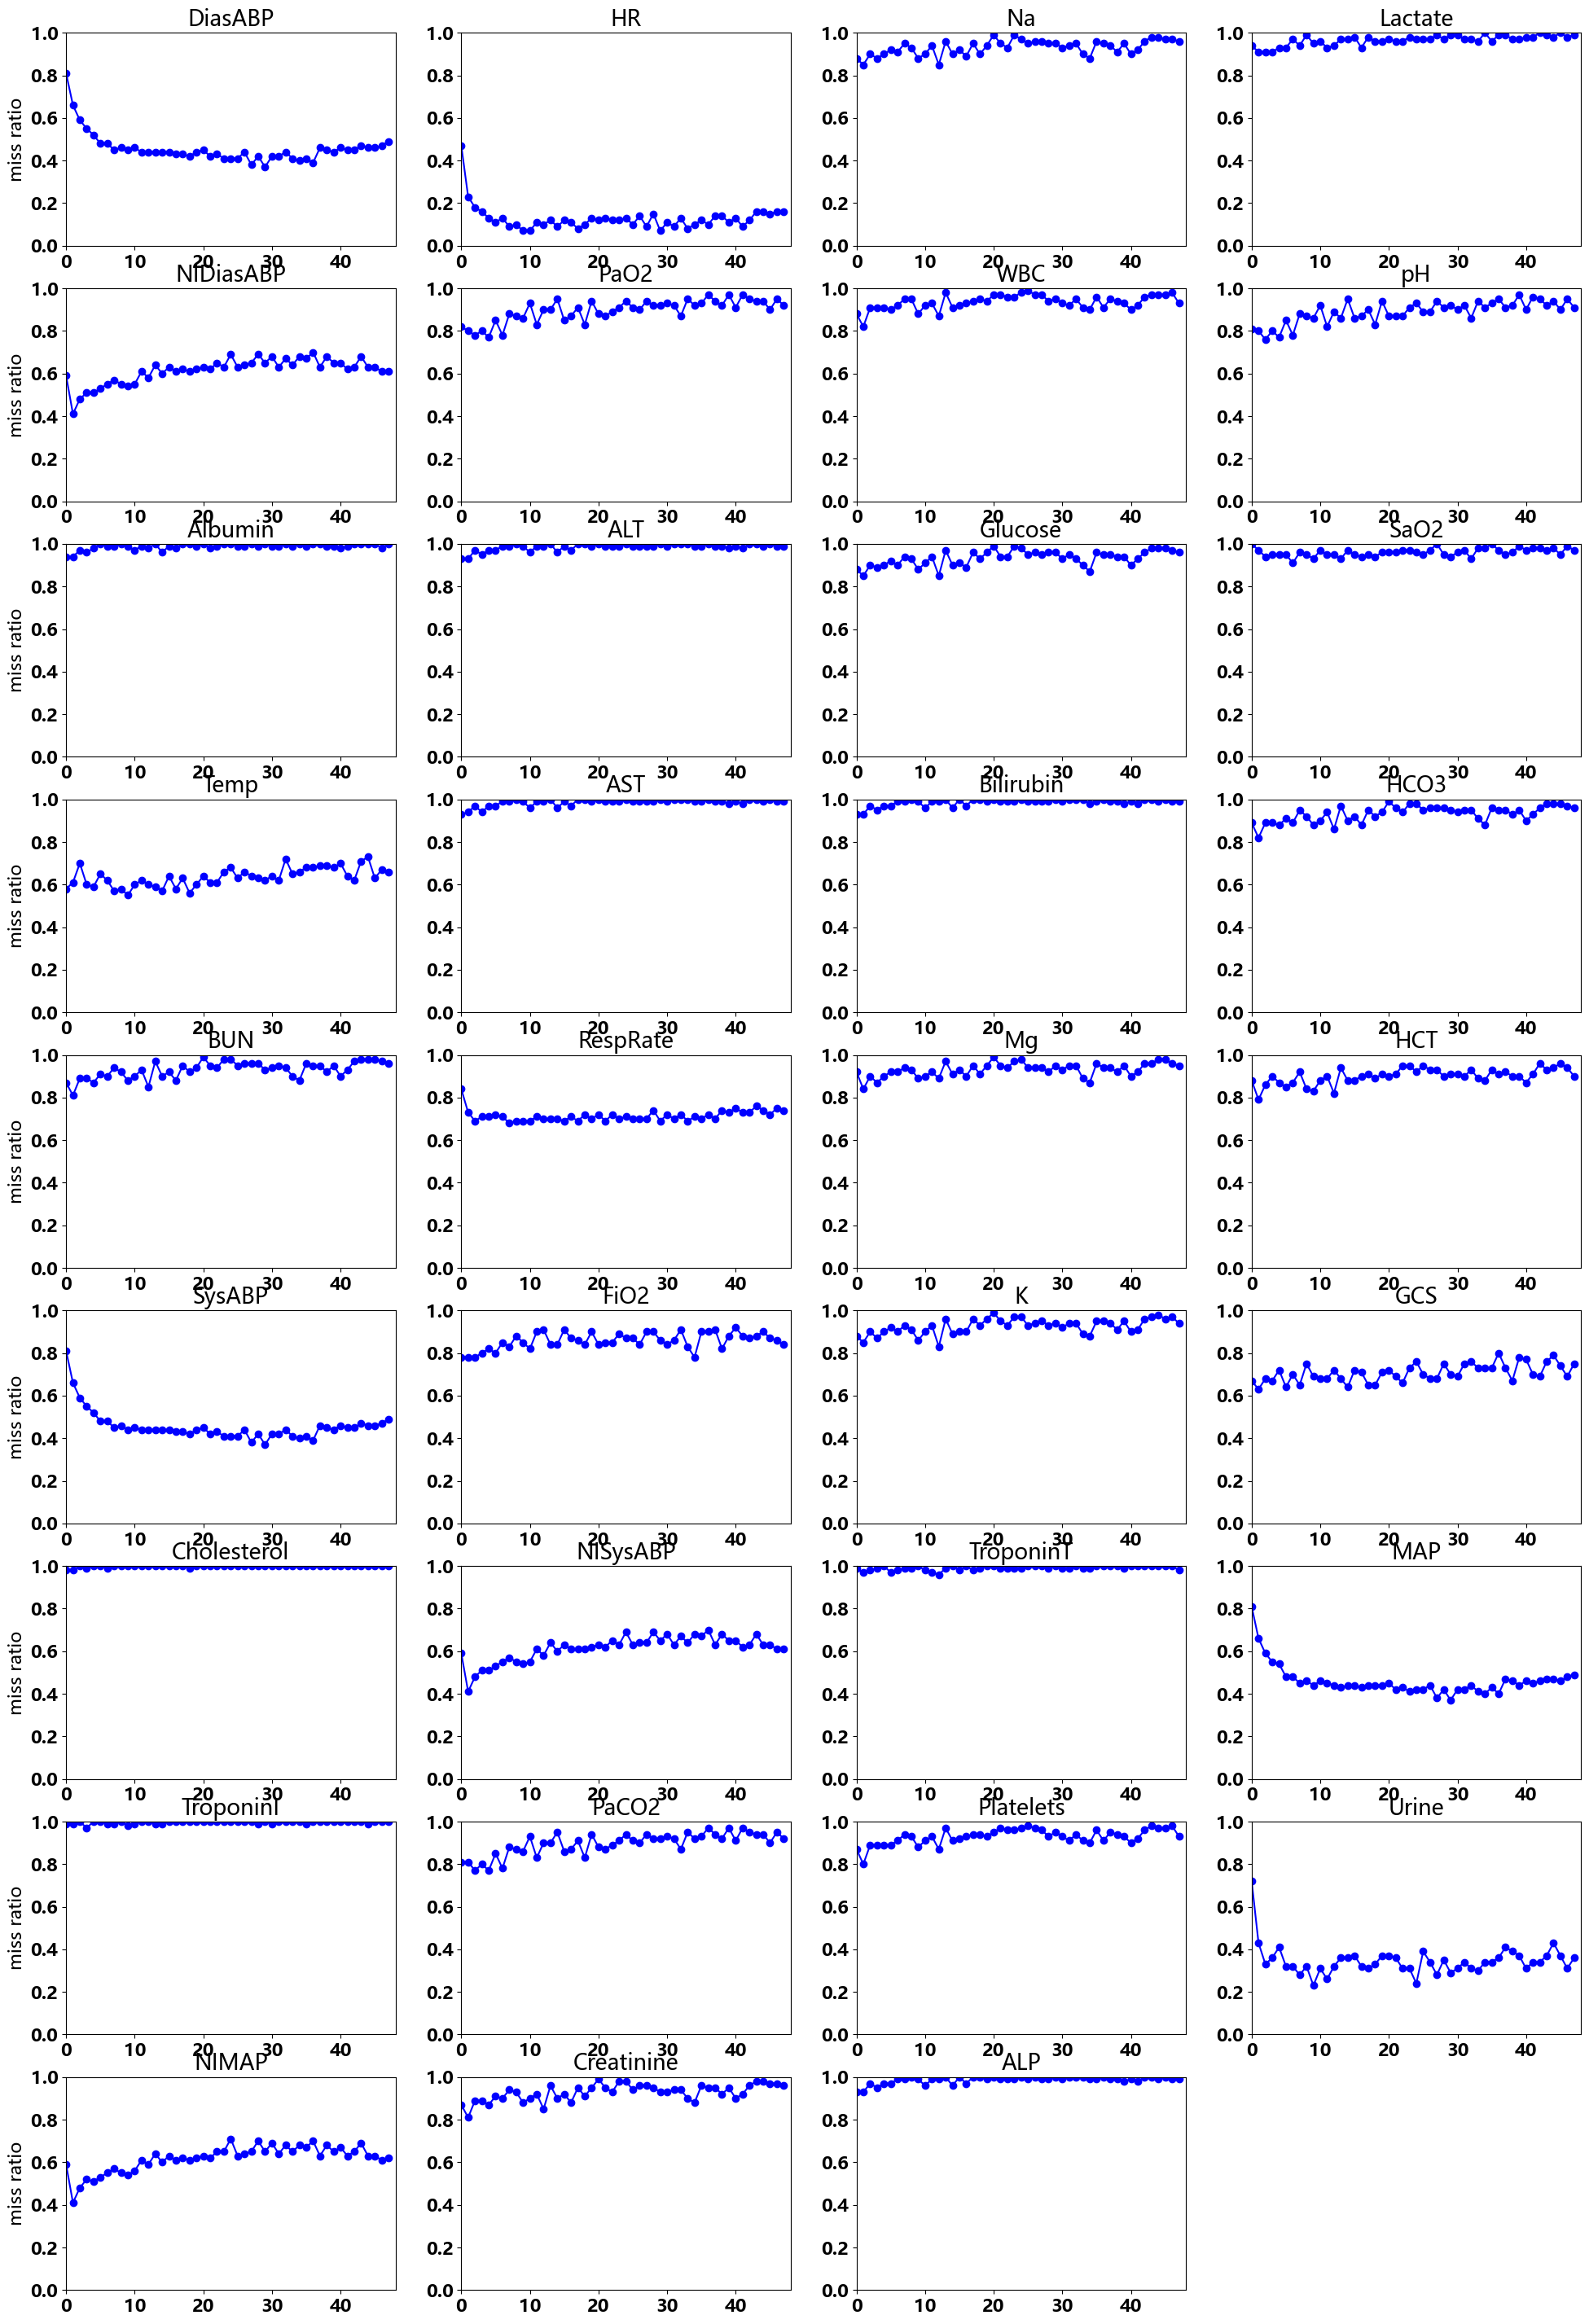

In [18]:
plt.rcParams["font.size"] = 16

fig, axes = plt.subplots(nrows=int(np.ceil(attr_count/4)), ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k,attr in zip(range(attr_count),attributes):
    df=pd.DataFrame({"x":np.arange(0,hour_count),"val":df_missRatio[attr]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o')
    axes[row][col].set_xlim((0,hour_count))
    axes[row][col].set_ylim((0.0,1.0))
    axes[row][col].set_title(attr)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='miss ratio')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='hour')
#plt.suptitle("observed values in sample data")
plt.show()

## correlations of missing pattern

In [111]:

def missVal_corr(x:np.ndarray,y:np.ndarray)->float:    
    """using Manhatten distance to represent similarity between boolean series"""
    sum_sim:float=0
    for _x,_y in zip(x,y):
        similarity=sum(_x==_y)/hour_count
        sum_sim+=similarity
    return sum_sim/len(x)

def corr(df:pd.DataFrame,method)->pd.DataFrame:
  """
  same as: `pd.dataframe.corr()`\\
  `corr()` from `pandas` somehow failed in transfering the `method` argument,
  so we manually calculate the correlation matrix"""
  labels=df.columns.to_list()
  label_count=len(labels)
  corr_mat=np.zeros((label_count,label_count))
  for i in range(0,label_count):
      for j in range(i,label_count):
        label1=labels[i]
        label2=labels[j]
        corr_mat[i][j]=method(df[label1],df[label2]) #type:ignore
      for j in range(0,i):  #the lower triangle part, omitted in heatmap below
        corr_mat[i][j]=corr_mat[j][i]
  return pd.DataFrame(corr_mat,columns=attributes,index=attributes)
   

<AxesSubplot: >

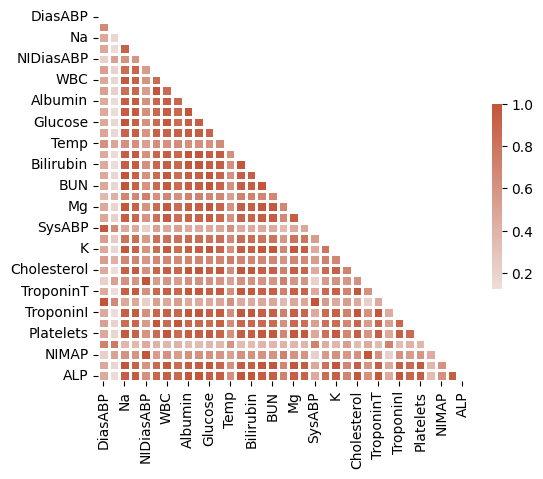

In [116]:
correlation=corr(df_missVal,missVal_corr)
mask = np.zeros_like(correlation, dtype=np.bool8)   
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask[np.triu_indices_from(mask)]= True      
sns.heatmap(correlation
            ,mask=mask       
            ,cmap=cmap
           , vmax=1
            , center=0
            ,square=True
            , linewidths=1
            , cbar_kws={"shrink": .5}
            , annot=False     
           )

## Z-score normalization

In [57]:
"""below is Z-score normalization, same as used in demo"""
df_normalize=pd.DataFrame(columns=attributes,index=id_list)
for attr in attributes:
    _values=np.array(df_all[attr].to_list()).transpose()
    mean=np.nanmean(_values,axis=1).reshape(-1,hour_count)
    std=np.nanstd(_values,axis=1).reshape(-1,hour_count)
    df_normalize[attr]=df_all[attr].map(lambda x:np.array((x-mean)/std,dtype=float)[0])
    

df_normalize.head(n=1)

,DiasABP,HR,Na,Lactate,NIDiasABP,PaO2,WBC,pH,Albumin,ALT,...,NISysABP,TroponinT,MAP,TroponinI,PaCO2,Platelets,Urine,NIMAP,Creatinine,ALP
132539,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.38396131422218305, -1.3128980359905302, -1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.2879678460430408, 0.24342541295068126, -0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",...,"[1.372344683917598, 0.7501618002756244, 0.1440...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-0.5634300377739445, -0.7124425759462417, 0.1...","[0.6560616017984555, 0.5954505720455671, -0.08...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [90]:
target_attr="HR"
_values=np.array(df_normalize[target_attr].to_list()).transpose()
_df=pd.DataFrame(_values,columns=id_list,index=range(0,hour_count))
_df.head()
    

,132539,132540,132541,132543,132545,132547,132548,132551,132554,132555,...,132769,132772,132773,132774,132776,132777,132780,132781,132783,132786
0,-0.383961,NaN,-0.323033,-0.566745,NaN,NaN,-0.627673,1.261094,NaN,-0.993241,...,1.017383,1.992230,NaN,NaN,1.870374,0.347175,-0.079321,-0.749529,-0.688601,NaN
1,-1.312898,0.206484,0.640593,-0.064834,NaN,NaN,-1.095844,0.369275,NaN,-0.444680,...,0.694856,1.400284,-0.010571,0.043693,1.291756,-0.336153,-0.227625,-0.498944,-0.607471,NaN
2,-1.026028,0.350619,1.091891,-0.443601,0.138827,NaN,-0.602445,NaN,NaN,-0.496549,...,1.197786,0.880099,0.297671,-0.761289,1.674318,-0.549497,-0.337705,-0.284757,-0.337705,NaN
3,-0.119335,0.323720,0.212956,-0.507008,0.656011,NaN,-0.507008,NaN,2.483613,-0.617771,...,NaN,0.988302,0.268338,-0.562390,1.929794,-0.839299,-0.174717,-0.285480,-0.507008,NaN
4,-0.459915,0.311678,0.256564,-0.459915,0.256564,-0.23946,NaN,NaN,2.461117,-0.184346,...,0.752589,0.697475,0.091223,0.256564,1.634410,-0.900826,-0.294574,-0.790598,-0.515029,NaN


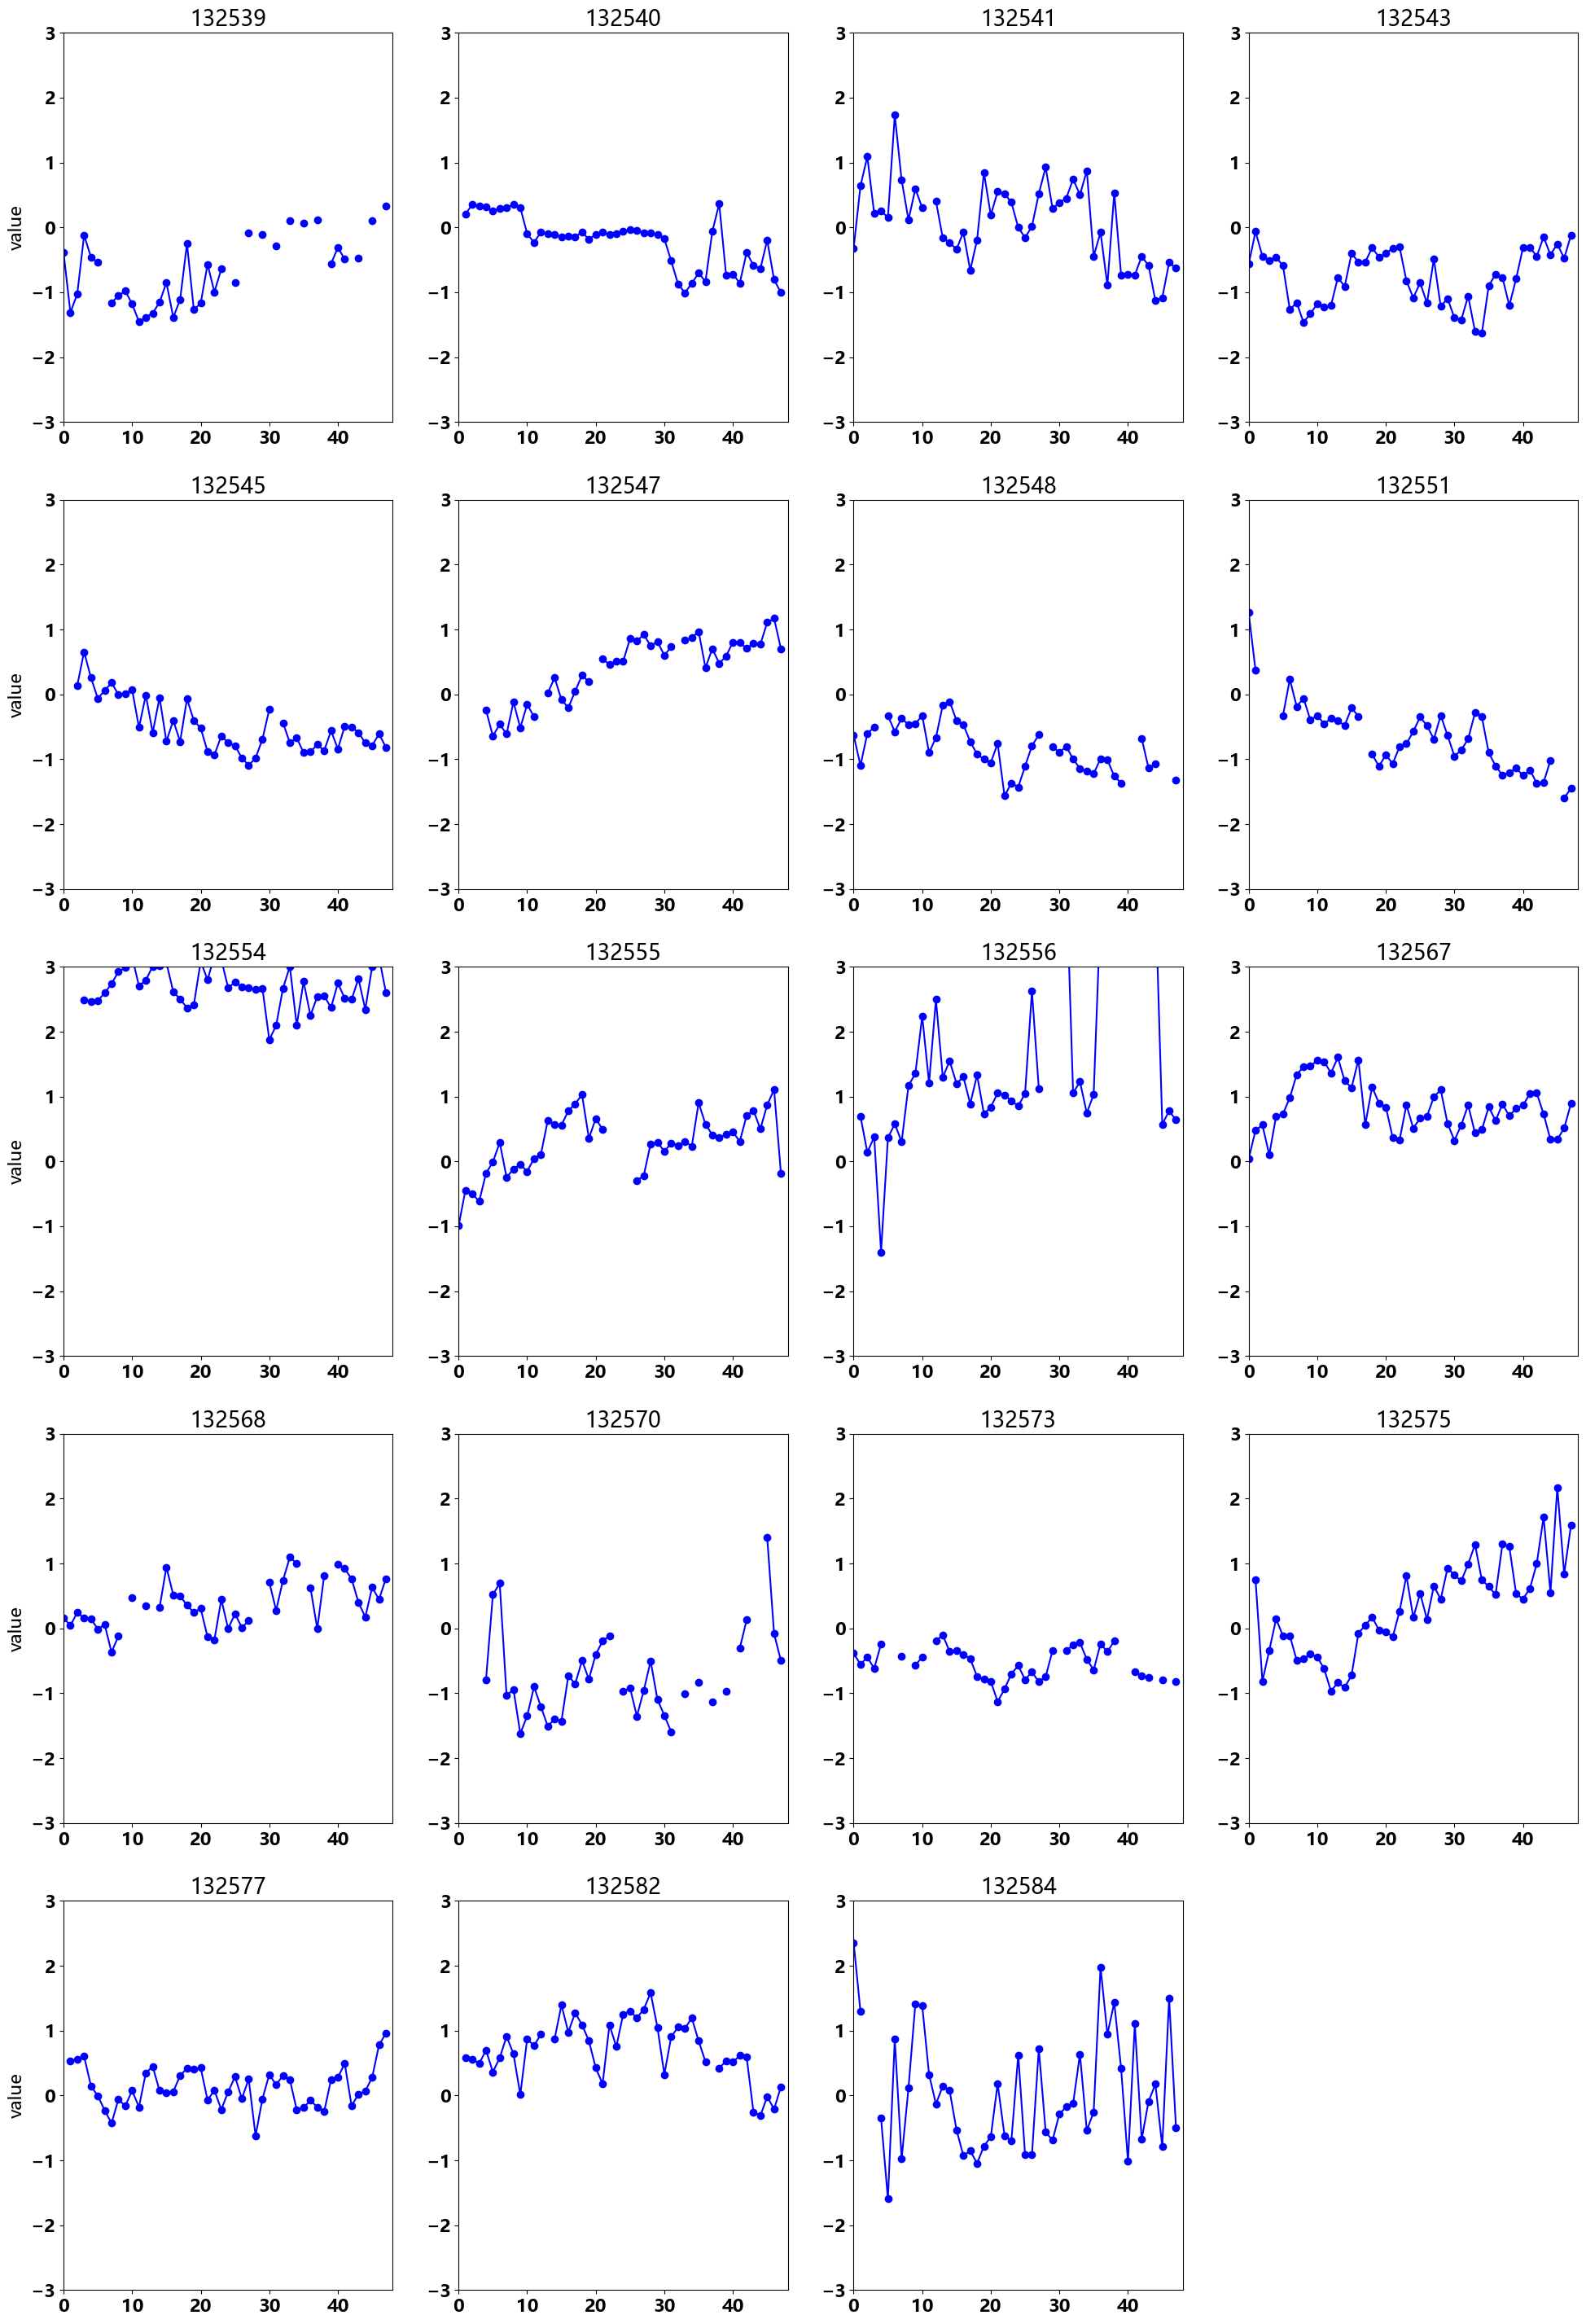

In [92]:
plt.rcParams["font.size"] = 16

fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

id_list=id_list[0:20]
for k,_id in zip(range(0,20),id_list):
    df=pd.DataFrame({"x":np.arange(0,hour_count),"val":_df[_id]})
    row = k // 4
    col = k % 4
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='-')
    axes[row][col].set_xlim((0,hour_count))
    axes[row][col].set_ylim((-3,3))
    axes[row][col].set_title(_id)
    
    
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='hour')
plt.show()

In [ ]:
def timeSeries_corr(x:np.ndarray,y:np.ndarray)->float:
   """correlation between two time series"""
   return 0